In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install transformers

Loaded 1200 samples.
Descriptions: ("A blue car with a sleek shape and medium size.'", "A white car with a sleek shape and large size.'", "A black car with a sleek shape and medium size.'")


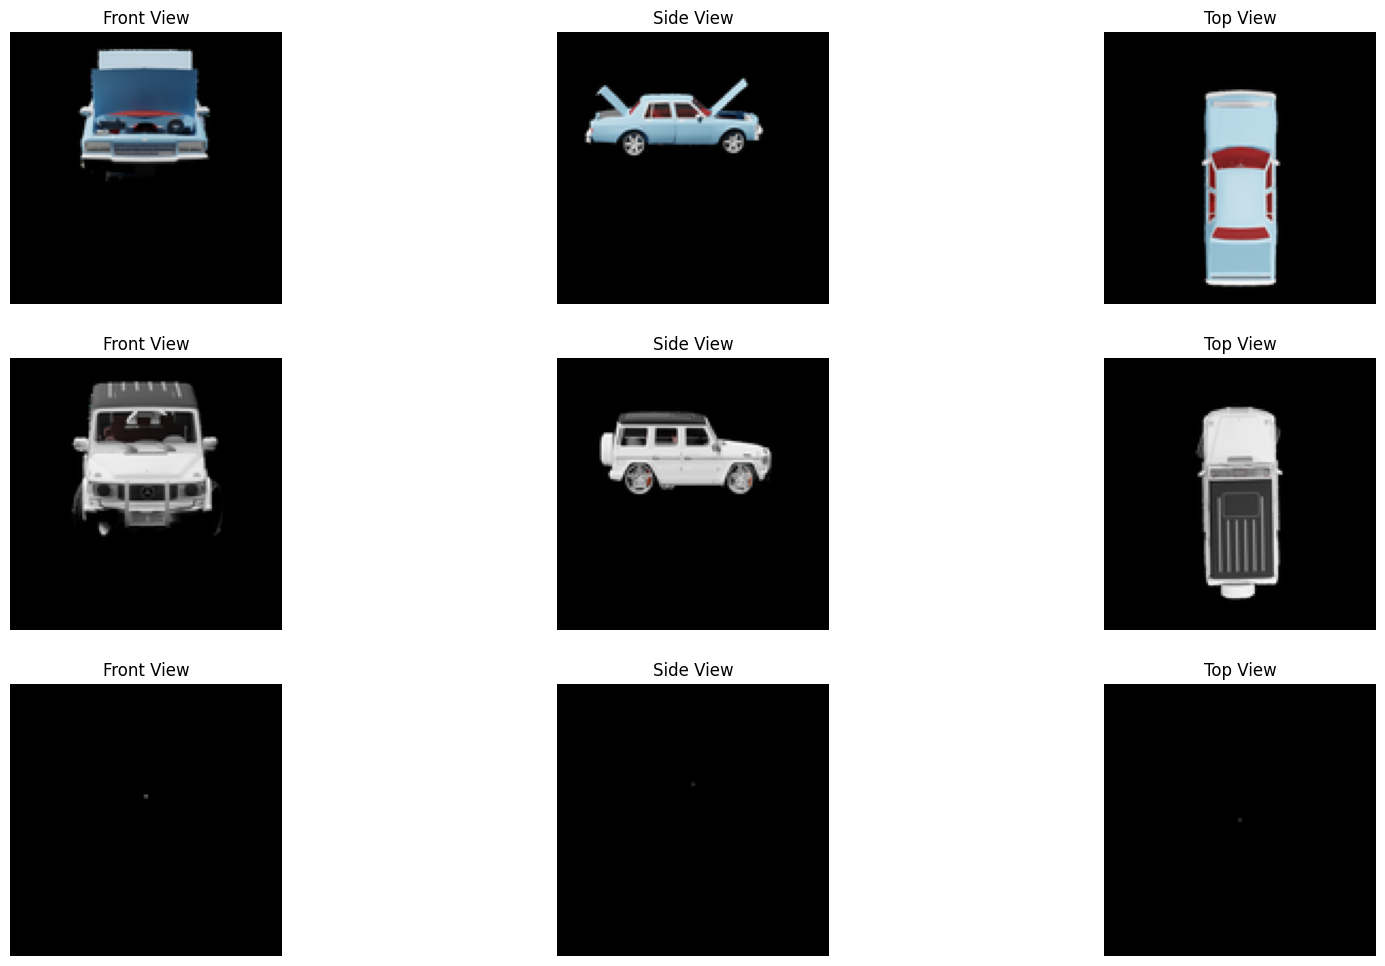

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Paths
ANNOTATION_FILE = "/content/drive/My Drive/CODE/description.txt"  # Update this path
IMAGE_DIR = "/content/drive/My Drive/CODE/rendered_images"        # Update this path

# Define image transforms with reduced resolution
image_transforms = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.LANCZOS),  # Reduce resolution to 128x128
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Dataset class with horizontal stretching and different zooming per view
class MultiViewDataset(Dataset):
    def __init__(self, descriptions, image_paths, transform=None, stretch_factor=1.6, zoom_factors=None):
        """
        Args:
            stretch_factor: Controls how much the image is stretched horizontally.
            zoom_factors: A dictionary specifying zoom factors for each view.
        """
        self.descriptions = descriptions
        self.image_paths = image_paths
        self.transform = transform
        self.stretch_factor = stretch_factor
        self.zoom_factors = zoom_factors

    def stretch_zoom_crop(self, img, zoom_factor):
        """
        Stretch the image horizontally, zoom into the center, and crop.
        """
        # Stretch the image horizontally
        width, height = img.size
        new_width = int(width * self.stretch_factor)
        stretched_img = img.resize((new_width, height), Image.LANCZOS)

        # Apply zoom by cropping the center
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)

        left = (stretched_img.width - new_width) // 2
        top = (stretched_img.height - new_height) // 2
        right = left + new_width
        bottom = top + new_height

        # Crop the zoomed-in portion
        return stretched_img.crop((left, top, right, bottom))

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        front, side, top = self.image_paths[idx]

        # Open images
        front_img = Image.open(front).convert("RGB")
        side_img = Image.open(side).convert("RGB")
        top_img = Image.open(top).convert("RGB")

        # Apply stretching and zooming with specific zoom factors for each view
        front_img = self.stretch_zoom_crop(front_img, self.zoom_factors["front"])
        side_img = self.stretch_zoom_crop(side_img, self.zoom_factors["side"])
        top_img = self.stretch_zoom_crop(top_img, self.zoom_factors["top"])

        # Apply transformations
        if self.transform:
            front_img = self.transform(front_img)
            side_img = self.transform(side_img)
            top_img = self.transform(top_img)

        return description, (front_img, side_img, top_img)

# Helper function to load annotations
def load_annotations(file_path, max_samples=1200):
    descriptions = []
    images = []
    missing_folders = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= max_samples:
                break
            parts = line.strip().split(", Description: ")
            model_id, description = parts[0], parts[1]

            # Remove quotes from model_id
            model_id = model_id.strip("'\"")

            # Folder path for images
            model_folder = os.path.join(IMAGE_DIR, model_id)

            # Paths to images
            front_img = os.path.join(model_folder, "front.png")
            side_img = os.path.join(model_folder, "side.png")
            top_img = os.path.join(model_folder, "top.png")

            # Check for missing data
            if not os.path.exists(model_folder):
                print(f"Missing folder: {model_folder}")
                missing_folders.append(model_id)
                continue
            if not (os.path.exists(front_img) and os.path.exists(side_img) and os.path.exists(top_img)):
                print(f"Missing images in folder: {model_folder}")
                missing_folders.append(model_id)
                continue

            descriptions.append(description)
            images.append((front_img, side_img, top_img))

    if missing_folders:
        print(f"Warning: Missing folders or files for models: {missing_folders}")

    print(f"Loaded {len(descriptions)} samples.")
    return descriptions, images

# Define specific zoom factors for each view
zoom_factors = {"front": 0.35, "side": 0.6, "top": 0.6}

# Load dataset with stretching and different zoom factors
descriptions, image_paths = load_annotations(ANNOTATION_FILE, max_samples=1200)
dataset = MultiViewDataset(descriptions, image_paths, transform=image_transforms, stretch_factor=1.6, zoom_factors=zoom_factors)

# Reload DataLoader with updated dataset
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Visualization function
def visualize_batch(data_loader):
    batch = next(iter(data_loader))
    descriptions, images = batch
    front, side, top = images
    print("Descriptions:", descriptions[:3])  # Print first 3 descriptions
    plt.figure(figsize=(20, 12))  # Adjust figure size
    for i in range(3):  # Visualize first 3 samples
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(front[i].permute(1, 2, 0) * 0.5 + 0.5)  # Denormalize
        plt.title(f"Front View")
        plt.axis("off")
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(side[i].permute(1, 2, 0) * 0.5 + 0.5)
        plt.title(f"Side View")
        plt.axis("off")
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(top[i].permute(1, 2, 0) * 0.5 + 0.5)
        plt.title(f"Top View")
        plt.axis("off")
    plt.show()

# Visualize a batch to verify the stretching and zooming effect
visualize_batch(dataloader)


In [4]:
from transformers import BertTokenizer, BertModel
import torch


# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Ensure the model is in evaluation mode
bert_model.eval()

def get_text_embeddings(descriptions, max_length=50):
    """
    Convert a list of text descriptions into embeddings using BERT.
    Args:
        descriptions (list of str): List of descriptions to convert to embeddings.
        max_length (int): Maximum length of the tokenized description.
    Returns:
        torch.Tensor: BERT-generated embeddings for the descriptions.
    """
    embeddings = []
    for description in descriptions:
        inputs = tokenizer(description, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1)  # Average pooling to get a fixed-size vector
        embeddings.append(embedding)

    return torch.stack(embeddings)


text_embeddings = get_text_embeddings(descriptions).to(device)
print(f"Text Embeddings Shape: {text_embeddings.shape}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Text Embeddings Shape: torch.Size([1200, 1, 768])


In [5]:
# Flatten text embeddings to match the expected shape (batch_size, text_embedding_dim)
text_embeddings = text_embeddings.squeeze(1)  # This will remove the second dimension of size 1
print(f"Updated Text Embeddings Shape: {text_embeddings.shape}")

Updated Text Embeddings Shape: torch.Size([1200, 768])


In [6]:
# Verify the sizes of images in the dataset
for idx in range(5):  # Check the first 5 samples
    description, (front_img, side_img, top_img) = dataset[idx]
    print(f"Sample {idx + 1}:")
    print(f"  Front Image Size: {front_img.size() if isinstance(front_img, torch.Tensor) else front_img.size}")
    print(f"  Side Image Size: {side_img.size() if isinstance(side_img, torch.Tensor) else side_img.size}")
    print(f"  Top Image Size: {top_img.size() if isinstance(top_img, torch.Tensor) else top_img.size}")
    print("-" * 40)


Sample 1:
  Front Image Size: torch.Size([3, 128, 128])
  Side Image Size: torch.Size([3, 128, 128])
  Top Image Size: torch.Size([3, 128, 128])
----------------------------------------
Sample 2:
  Front Image Size: torch.Size([3, 128, 128])
  Side Image Size: torch.Size([3, 128, 128])
  Top Image Size: torch.Size([3, 128, 128])
----------------------------------------
Sample 3:
  Front Image Size: torch.Size([3, 128, 128])
  Side Image Size: torch.Size([3, 128, 128])
  Top Image Size: torch.Size([3, 128, 128])
----------------------------------------
Sample 4:
  Front Image Size: torch.Size([3, 128, 128])
  Side Image Size: torch.Size([3, 128, 128])
  Top Image Size: torch.Size([3, 128, 128])
----------------------------------------
Sample 5:
  Front Image Size: torch.Size([3, 128, 128])
  Side Image Size: torch.Size([3, 128, 128])
  Top Image Size: torch.Size([3, 128, 128])
----------------------------------------


Epoch [1/200]
  Front View: D Loss: -23386.0367, G Loss: 28876.5072
  Side View:  D Loss: -15823.8333, G Loss: 9866.6171
  Top View:   D Loss: -20362.9999, G Loss: 13600.7335
Epoch [2/200]
  Front View: D Loss: -4041.5465, G Loss: 23533.2763
  Side View:  D Loss: -1958.4336, G Loss: 3235.0758
  Top View:   D Loss: -2330.1944, G Loss: 3149.7921
Epoch [3/200]
  Front View: D Loss: -5905.2649, G Loss: 19824.0475
  Side View:  D Loss: -3002.1705, G Loss: 3441.0720
  Top View:   D Loss: -3426.2076, G Loss: 7370.4301
Epoch [4/200]
  Front View: D Loss: -7930.5084, G Loss: 24887.2936
  Side View:  D Loss: -3413.8585, G Loss: 4129.8514
  Top View:   D Loss: -5706.3784, G Loss: 13138.2281
Epoch [5/200]
  Front View: D Loss: -9926.6450, G Loss: 28702.9218
  Side View:  D Loss: -3925.9389, G Loss: 5178.8896
  Top View:   D Loss: -6671.6776, G Loss: 15438.8589
Epoch [6/200]
  Front View: D Loss: -9981.4279, G Loss: 30225.0810
  Side View:  D Loss: -3836.7165, G Loss: 6604.5726
  Top View:   D Loss

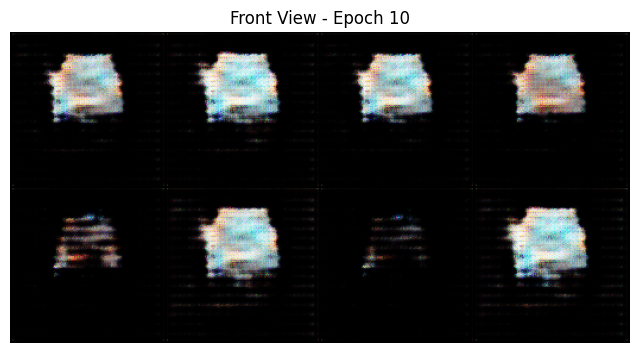

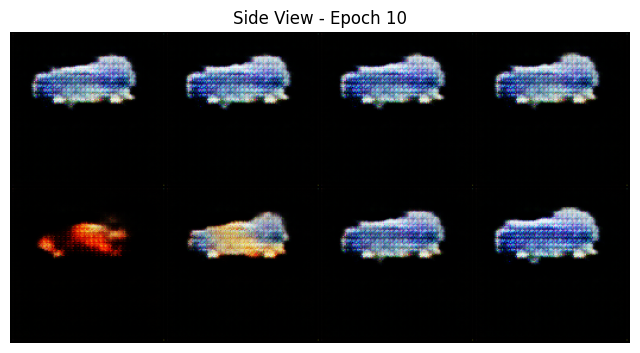

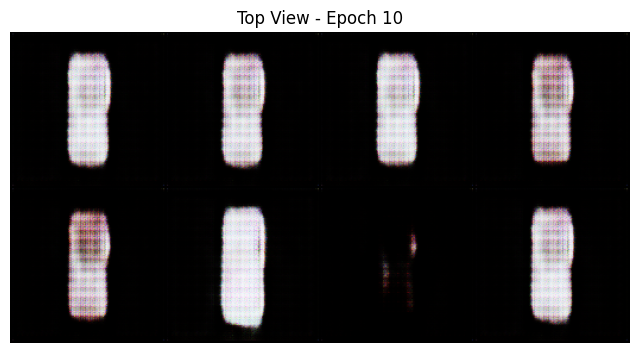

Epoch [11/200]
  Front View: D Loss: -6251.9023, G Loss: 23708.4473
  Side View:  D Loss: -3000.8582, G Loss: 12189.9885
  Top View:   D Loss: -3590.2931, G Loss: 9912.3234
Epoch [12/200]
  Front View: D Loss: -5468.6204, G Loss: 21173.9702
  Side View:  D Loss: -3282.0659, G Loss: 14126.2846
  Top View:   D Loss: -2742.9795, G Loss: 9014.9422
Epoch [13/200]
  Front View: D Loss: -3645.8530, G Loss: 22844.7505
  Side View:  D Loss: -3366.5175, G Loss: 12700.9261
  Top View:   D Loss: -2838.9911, G Loss: 9075.4818
Epoch [14/200]
  Front View: D Loss: -3123.8206, G Loss: 23564.0582
  Side View:  D Loss: -3573.0950, G Loss: 13629.2881
  Top View:   D Loss: -2584.3703, G Loss: 13792.5637
Epoch [15/200]
  Front View: D Loss: -3355.0042, G Loss: 23632.6346
  Side View:  D Loss: -3498.7485, G Loss: 13329.0153
  Top View:   D Loss: -3105.6465, G Loss: 11378.5764
Epoch [16/200]
  Front View: D Loss: -3434.1002, G Loss: 26415.3967
  Side View:  D Loss: -2642.9362, G Loss: 15065.6003
  Top View: 

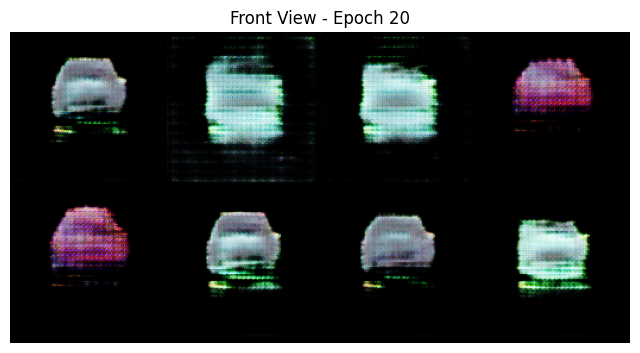

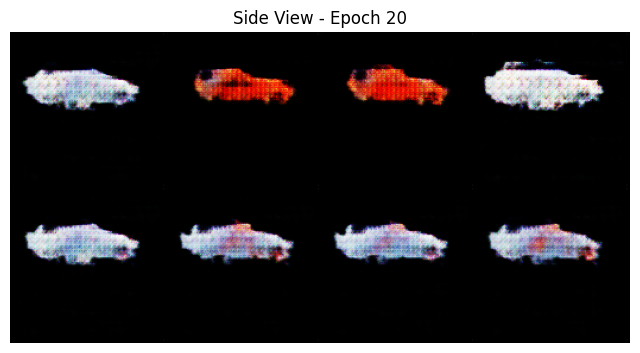

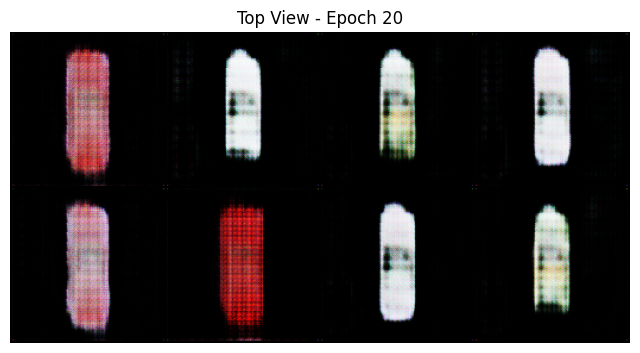

Epoch [21/200]
  Front View: D Loss: -2408.0379, G Loss: 24616.7192
  Side View:  D Loss: -2043.7600, G Loss: 17048.0478
  Top View:   D Loss: -2778.3828, G Loss: 11145.3773
Epoch [22/200]
  Front View: D Loss: -2262.2032, G Loss: 24281.2936
  Side View:  D Loss: -2825.0094, G Loss: 15632.3527
  Top View:   D Loss: -2259.5910, G Loss: 8595.3861
Epoch [23/200]
  Front View: D Loss: -2292.0779, G Loss: 23883.8795
  Side View:  D Loss: -3172.5127, G Loss: 16612.9541
  Top View:   D Loss: -2302.4911, G Loss: 11298.9250
Epoch [24/200]
  Front View: D Loss: -2381.5735, G Loss: 25918.7749
  Side View:  D Loss: -2323.7459, G Loss: 17140.8603
  Top View:   D Loss: -1677.4708, G Loss: 9374.6445
Epoch [25/200]
  Front View: D Loss: -2169.2603, G Loss: 26946.1305
  Side View:  D Loss: -1507.0156, G Loss: 20193.3701
  Top View:   D Loss: -2610.2012, G Loss: 8656.8181
Models saved at epoch 25.
Epoch [26/200]
  Front View: D Loss: -2121.2194, G Loss: 25453.1053
  Side View:  D Loss: -2198.1293, G Los

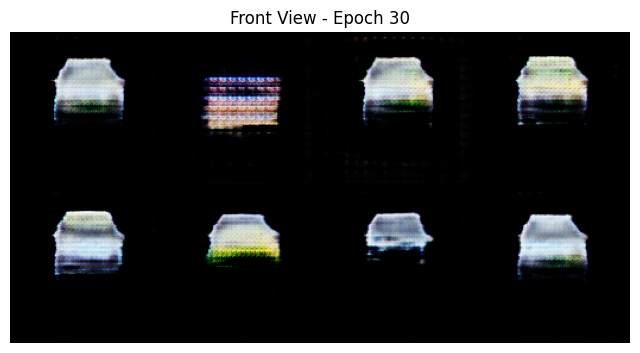

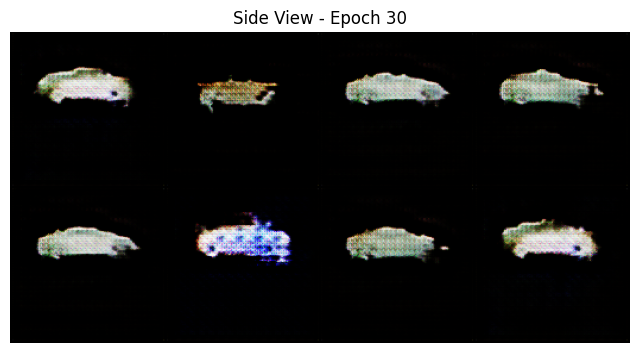

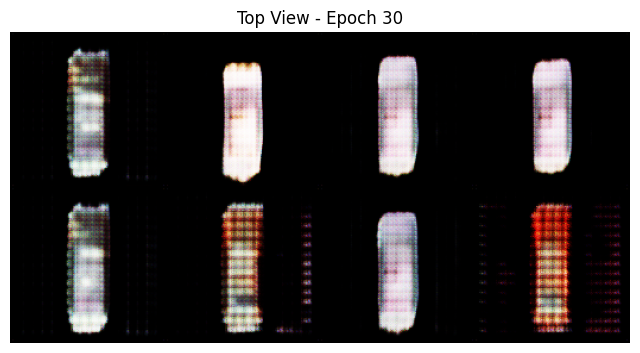

Epoch [31/200]
  Front View: D Loss: -1978.3766, G Loss: 29398.0970
  Side View:  D Loss: -1842.8773, G Loss: 13117.2118
  Top View:   D Loss: -864.6316, G Loss: 15982.4558
Epoch [32/200]
  Front View: D Loss: -1681.6026, G Loss: 31194.5443
  Side View:  D Loss: -2233.7083, G Loss: 15870.9344
  Top View:   D Loss: -842.2368, G Loss: 10253.7341
Epoch [33/200]
  Front View: D Loss: -2098.5841, G Loss: 32804.3857
  Side View:  D Loss: -2047.3176, G Loss: 15057.3701
  Top View:   D Loss: -1271.6360, G Loss: 13350.4504
Epoch [34/200]
  Front View: D Loss: -1913.0569, G Loss: 29503.9401
  Side View:  D Loss: -2345.1847, G Loss: 15403.8725
  Top View:   D Loss: -1214.4510, G Loss: 16204.8008
Epoch [35/200]
  Front View: D Loss: -1917.4211, G Loss: 30470.7336
  Side View:  D Loss: -1700.0512, G Loss: 18337.1865
  Top View:   D Loss: -1329.5513, G Loss: 17035.5536
Epoch [36/200]
  Front View: D Loss: -1552.3587, G Loss: 31932.4290
  Side View:  D Loss: -1878.6230, G Loss: 18054.1529
  Top View:

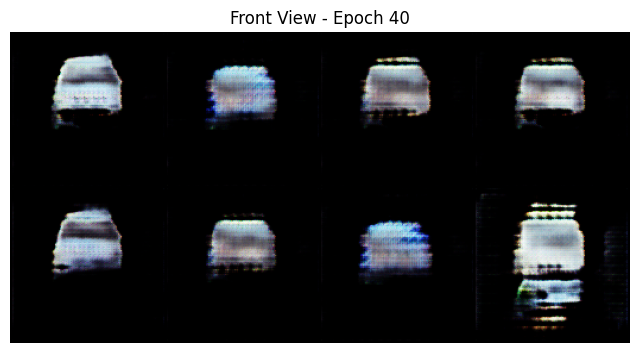

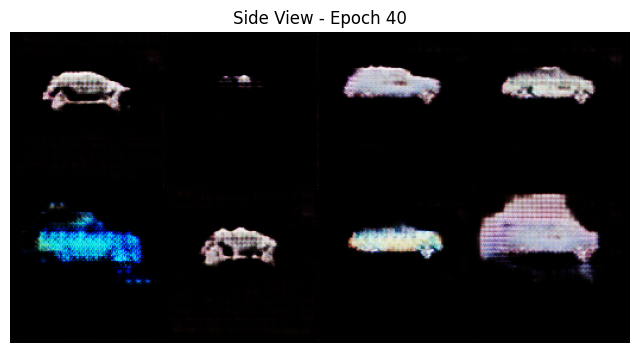

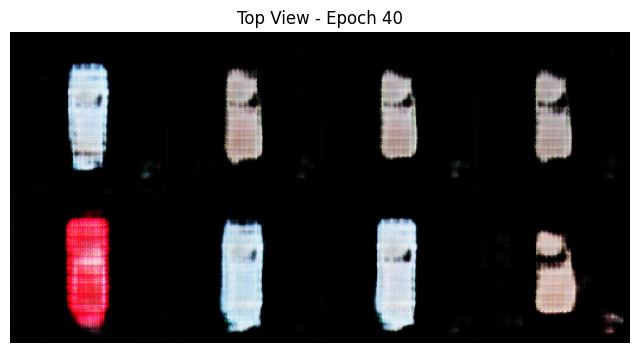

Epoch [41/200]
  Front View: D Loss: -1728.6606, G Loss: 32734.5939
  Side View:  D Loss: -1854.2507, G Loss: 17714.9469
  Top View:   D Loss: -1778.4332, G Loss: 17440.4651
Epoch [42/200]
  Front View: D Loss: -1780.1130, G Loss: 32145.5234
  Side View:  D Loss: -1713.1937, G Loss: 18849.2129
  Top View:   D Loss: -2176.6532, G Loss: 16346.4337
Epoch [43/200]
  Front View: D Loss: -1665.6013, G Loss: 32835.9045
  Side View:  D Loss: -1399.7912, G Loss: 19145.9387
  Top View:   D Loss: -1826.7758, G Loss: 15747.4358
Epoch [44/200]
  Front View: D Loss: -1529.6867, G Loss: 30159.5070
  Side View:  D Loss: -1026.0877, G Loss: 16730.3619
  Top View:   D Loss: -2128.5998, G Loss: 20783.5135
Epoch [45/200]
  Front View: D Loss: -1867.9232, G Loss: 35762.2959
  Side View:  D Loss: -1428.3010, G Loss: 19229.4107
  Top View:   D Loss: -2012.8076, G Loss: 17860.4762
Epoch [46/200]
  Front View: D Loss: -1923.4874, G Loss: 33165.4330
  Side View:  D Loss: -1489.8959, G Loss: 16932.6380
  Top Vie

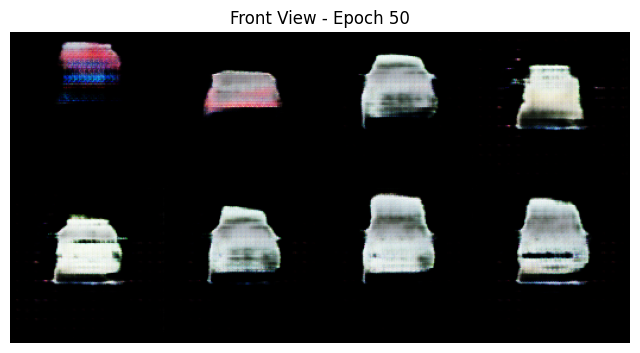

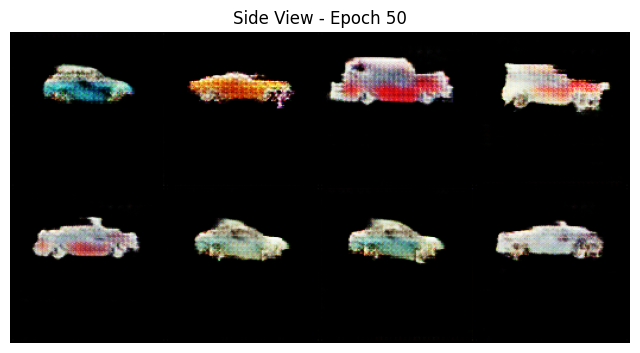

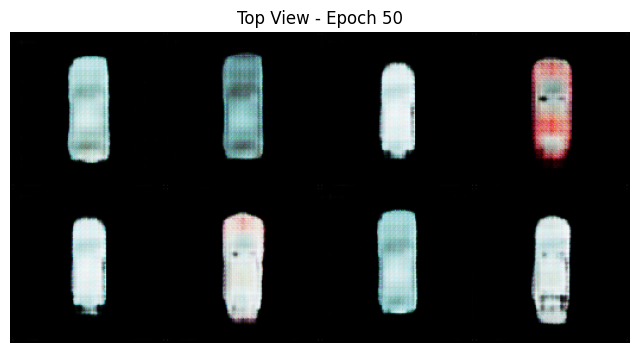

Models saved at epoch 50.
Epoch [51/200]
  Front View: D Loss: -1909.7773, G Loss: 32499.5724
  Side View:  D Loss: -1703.4498, G Loss: 15109.7575
  Top View:   D Loss: -2148.0274, G Loss: 22078.6816
Epoch [52/200]
  Front View: D Loss: -1823.2905, G Loss: 31463.6234
  Side View:  D Loss: -1568.6484, G Loss: 15581.0302
  Top View:   D Loss: -2034.5624, G Loss: 20369.6327
Epoch [53/200]
  Front View: D Loss: -2014.3642, G Loss: 34030.6539
  Side View:  D Loss: -1521.8074, G Loss: 15605.2542
  Top View:   D Loss: -2537.3045, G Loss: 22057.0549
Epoch [54/200]
  Front View: D Loss: -1880.3092, G Loss: 34553.6232
  Side View:  D Loss: -1177.7514, G Loss: 14091.1580
  Top View:   D Loss: -2829.7266, G Loss: 23020.8491
Epoch [55/200]
  Front View: D Loss: -1791.3352, G Loss: 36652.6634
  Side View:  D Loss: -1172.8870, G Loss: 15898.5219
  Top View:   D Loss: -2619.3303, G Loss: 23266.4392
Epoch [56/200]
  Front View: D Loss: -1398.2090, G Loss: 33388.1118
  Side View:  D Loss: -1506.2565, G 

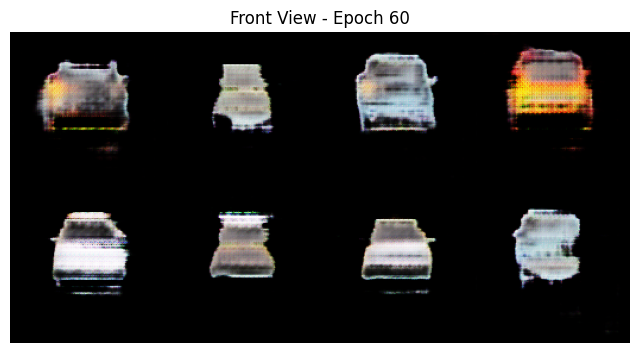

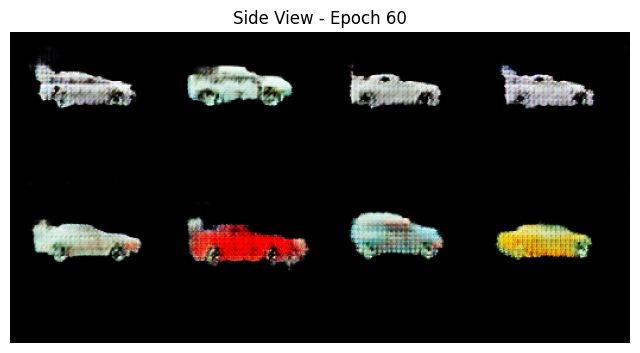

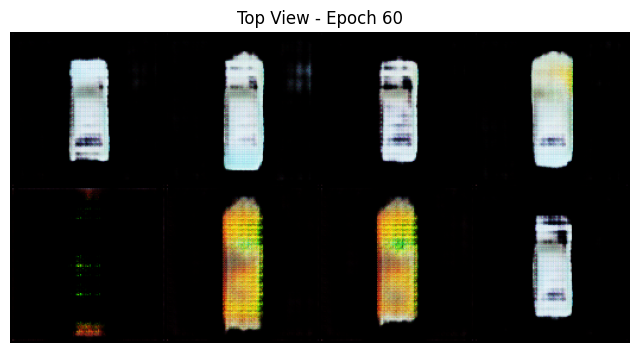

Epoch [61/200]
  Front View: D Loss: -2106.4867, G Loss: 36722.2961
  Side View:  D Loss: -642.4049, G Loss: 22904.5604
  Top View:   D Loss: -2066.7237, G Loss: 24485.0134
Epoch [62/200]
  Front View: D Loss: -2328.3721, G Loss: 36124.1357
  Side View:  D Loss: -1059.8212, G Loss: 23540.4805
  Top View:   D Loss: -150.4714, G Loss: 7678.4993
Epoch [63/200]
  Front View: D Loss: -1733.6162, G Loss: 33644.1272
  Side View:  D Loss: -1172.6692, G Loss: 22946.8502
  Top View:   D Loss: -406.4450, G Loss: 10498.5506
Epoch [64/200]
  Front View: D Loss: -749.3012, G Loss: 27244.9378
  Side View:  D Loss: -1246.9003, G Loss: 22929.0559
  Top View:   D Loss: -251.4233, G Loss: 10530.3833
Epoch [65/200]
  Front View: D Loss: -887.9834, G Loss: 27778.4454
  Side View:  D Loss: -1292.2593, G Loss: 20460.7166
  Top View:   D Loss: -451.2973, G Loss: 10640.0066
Epoch [66/200]
  Front View: D Loss: -865.5724, G Loss: 29254.2873
  Side View:  D Loss: -1459.2418, G Loss: 18492.7361
  Top View:   D Lo

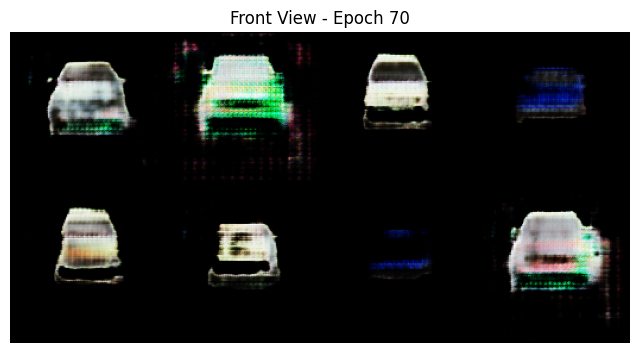

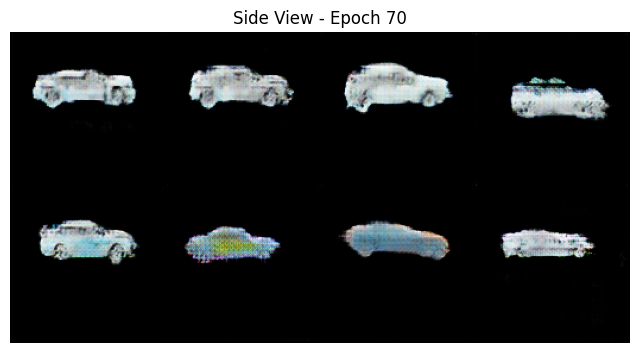

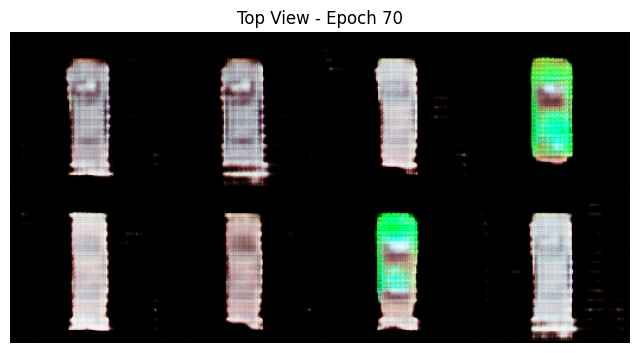

Epoch [71/200]
  Front View: D Loss: -1171.6230, G Loss: 28714.4845
  Side View:  D Loss: -1410.0031, G Loss: 14713.5319
  Top View:   D Loss: -659.4596, G Loss: 15282.4179
Epoch [72/200]
  Front View: D Loss: -1434.2989, G Loss: 30731.7083
  Side View:  D Loss: -792.4276, G Loss: 14148.8464
  Top View:   D Loss: -883.9258, G Loss: 15091.1820
Epoch [73/200]
  Front View: D Loss: -1569.7598, G Loss: 31704.3245
  Side View:  D Loss: -1261.1686, G Loss: 16366.2213
  Top View:   D Loss: -1109.9029, G Loss: 17812.5702
Epoch [74/200]
  Front View: D Loss: -1538.8795, G Loss: 31272.2606
  Side View:  D Loss: -970.2724, G Loss: 15127.2160
  Top View:   D Loss: -896.4875, G Loss: 15456.6760
Epoch [75/200]
  Front View: D Loss: -1753.7687, G Loss: 32974.9513
  Side View:  D Loss: -614.7864, G Loss: 17944.6829
  Top View:   D Loss: -921.4602, G Loss: 19358.2669
Models saved at epoch 75.
Epoch [76/200]
  Front View: D Loss: -1740.5002, G Loss: 33987.4994
  Side View:  D Loss: -955.8881, G Loss: 19

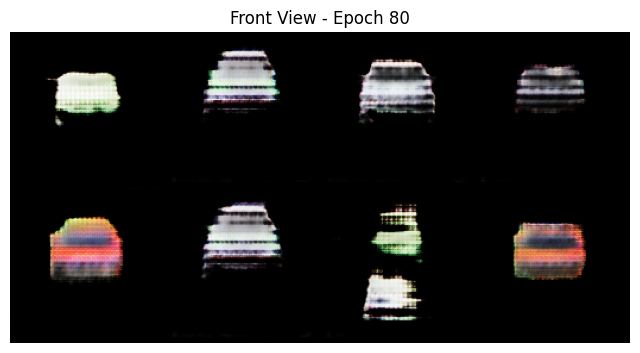

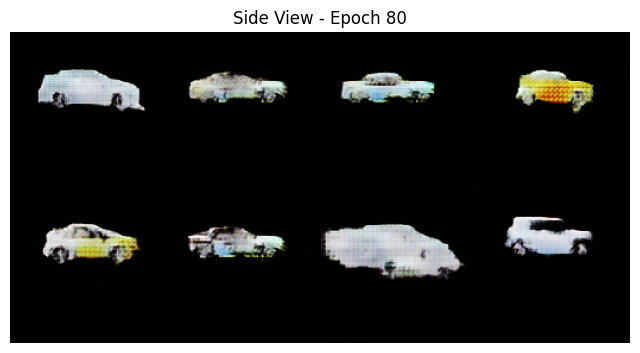

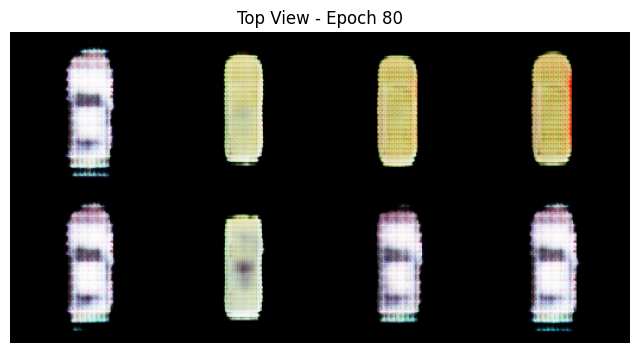

Epoch [81/200]
  Front View: D Loss: -1901.6645, G Loss: 36192.3605
  Side View:  D Loss: -1781.6749, G Loss: 12878.3612
  Top View:   D Loss: -1409.4493, G Loss: 18097.8976
Epoch [82/200]
  Front View: D Loss: -2039.7749, G Loss: 36495.1478
  Side View:  D Loss: -911.2377, G Loss: 10241.5416
  Top View:   D Loss: -1644.5013, G Loss: 19954.3186
Epoch [83/200]
  Front View: D Loss: -1267.2664, G Loss: 35559.7875
  Side View:  D Loss: -1412.5564, G Loss: 14101.3976
  Top View:   D Loss: -1312.5236, G Loss: 19252.5557
Epoch [84/200]
  Front View: D Loss: -1187.2506, G Loss: 36356.1105
  Side View:  D Loss: -1454.9346, G Loss: 14395.0553
  Top View:   D Loss: -1862.9689, G Loss: 12503.1479
Epoch [85/200]
  Front View: D Loss: -1137.2422, G Loss: 39626.7343
  Side View:  D Loss: -949.7513, G Loss: 14447.9672
  Top View:   D Loss: -1827.1356, G Loss: 17584.9560
Epoch [86/200]
  Front View: D Loss: -1502.1520, G Loss: 36178.9561
  Side View:  D Loss: -1024.2534, G Loss: 17949.0557
  Top View:

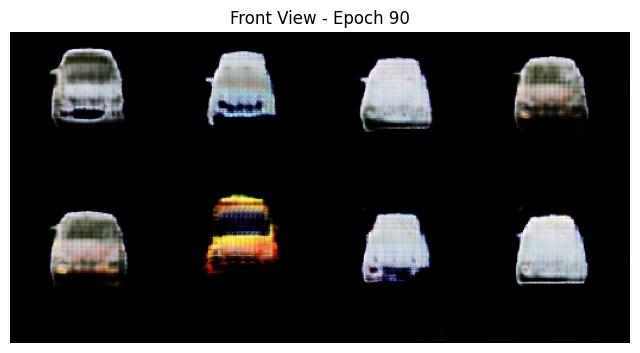

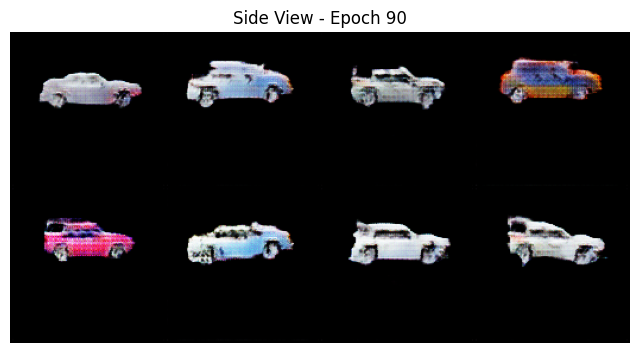

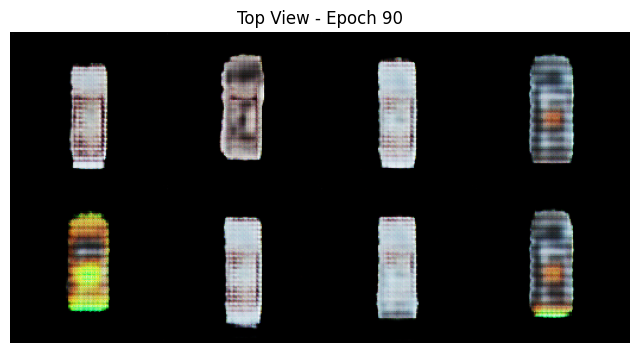

Epoch [91/200]
  Front View: D Loss: -885.7662, G Loss: 42910.0231
  Side View:  D Loss: -640.8569, G Loss: 22053.5388
  Top View:   D Loss: -2055.3914, G Loss: 19761.9379
Epoch [92/200]
  Front View: D Loss: -813.6107, G Loss: 38772.6358
  Side View:  D Loss: -880.3226, G Loss: 22059.8093
  Top View:   D Loss: -2254.1086, G Loss: 21821.6713
Epoch [93/200]
  Front View: D Loss: -845.9408, G Loss: 41091.4816
  Side View:  D Loss: -1109.8303, G Loss: 20429.8012
  Top View:   D Loss: -2151.8629, G Loss: 24035.2971
Epoch [94/200]
  Front View: D Loss: -881.1488, G Loss: 42799.4962
  Side View:  D Loss: -1298.3401, G Loss: 20365.7854
  Top View:   D Loss: -2290.6706, G Loss: 26232.8951
Epoch [95/200]
  Front View: D Loss: -901.7176, G Loss: 42057.1826
  Side View:  D Loss: -1625.2246, G Loss: 18554.6763
  Top View:   D Loss: -2259.5301, G Loss: 27725.2839
Epoch [96/200]
  Front View: D Loss: -899.8887, G Loss: 40353.1278
  Side View:  D Loss: -1550.6429, G Loss: 16035.8631
  Top View:   D L

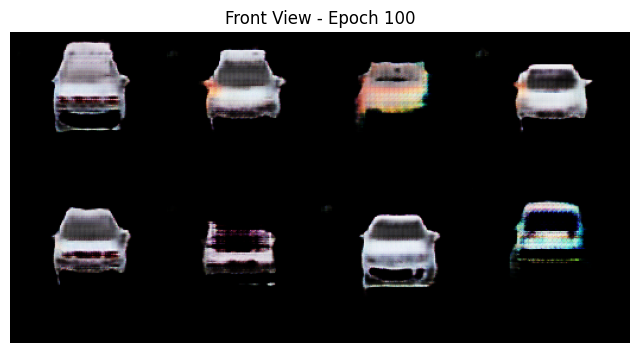

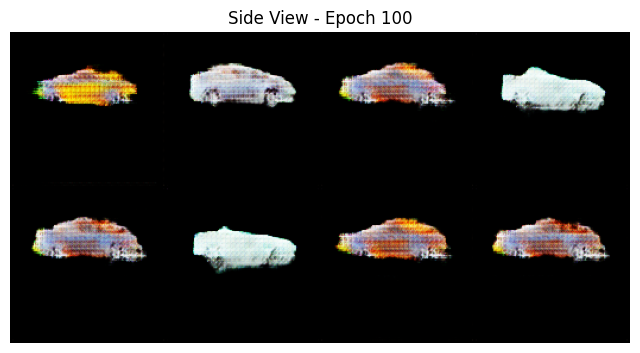

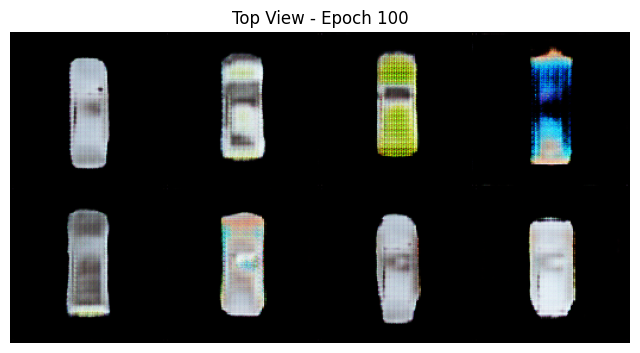

Models saved at epoch 100.
Epoch [101/200]
  Front View: D Loss: -1149.8960, G Loss: 41002.3927
  Side View:  D Loss: -547.3369, G Loss: 22050.5191
  Top View:   D Loss: -2075.8696, G Loss: 20069.4777
Epoch [102/200]
  Front View: D Loss: -1220.4805, G Loss: 40341.4972
  Side View:  D Loss: -805.2167, G Loss: 24199.2237
  Top View:   D Loss: -1999.3996, G Loss: 22216.2059
Epoch [103/200]
  Front View: D Loss: -1435.7552, G Loss: 37661.2521
  Side View:  D Loss: -1065.8243, G Loss: 24317.1879
  Top View:   D Loss: -2188.4691, G Loss: 24289.2531
Epoch [104/200]
  Front View: D Loss: -1272.4508, G Loss: 36186.2131
  Side View:  D Loss: -1302.1655, G Loss: 26166.7345
  Top View:   D Loss: -2206.5245, G Loss: 25514.4498
Epoch [105/200]
  Front View: D Loss: -1456.1738, G Loss: 35945.5010
  Side View:  D Loss: -1436.4008, G Loss: 26254.1505
  Top View:   D Loss: -1574.6674, G Loss: 25115.1243
Epoch [106/200]
  Front View: D Loss: -1467.8391, G Loss: 37867.6667
  Side View:  D Loss: -1431.863

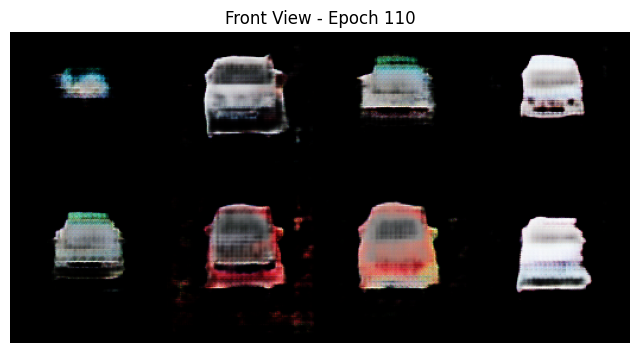

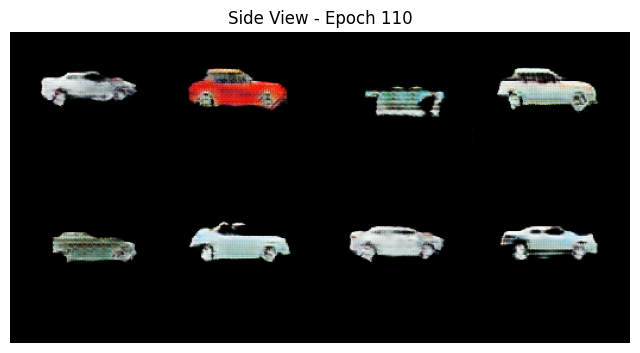

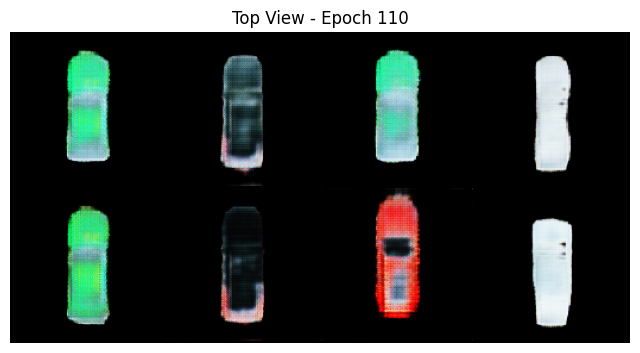

Epoch [111/200]
  Front View: D Loss: -1340.2330, G Loss: 36784.7159
  Side View:  D Loss: -1623.3178, G Loss: 24553.3092
  Top View:   D Loss: -1519.3101, G Loss: 25701.5904
Epoch [112/200]
  Front View: D Loss: -1278.3760, G Loss: 36708.6701
  Side View:  D Loss: -1617.6319, G Loss: 24466.6445
  Top View:   D Loss: -1820.0123, G Loss: 25734.4478
Epoch [113/200]
  Front View: D Loss: -1507.4166, G Loss: 34768.3273
  Side View:  D Loss: -1290.1449, G Loss: 22016.6680
  Top View:   D Loss: -2256.7027, G Loss: 27477.4552
Epoch [114/200]
  Front View: D Loss: -1425.4432, G Loss: 35642.9424
  Side View:  D Loss: -1692.5491, G Loss: 22139.6834
  Top View:   D Loss: -2111.1517, G Loss: 24429.1252
Epoch [115/200]
  Front View: D Loss: -1342.1138, G Loss: 34917.9777
  Side View:  D Loss: -1795.6678, G Loss: 20154.3971
  Top View:   D Loss: -1857.2917, G Loss: 20948.4983
Epoch [116/200]
  Front View: D Loss: -933.5963, G Loss: 35619.7153
  Side View:  D Loss: -1282.4299, G Loss: 19379.2794
  To

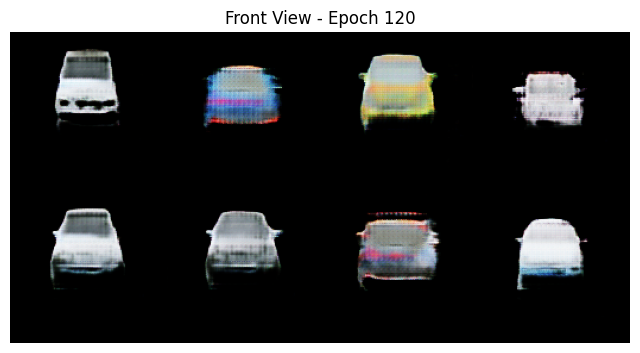

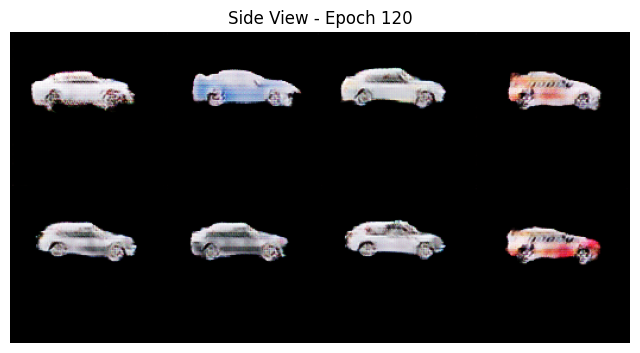

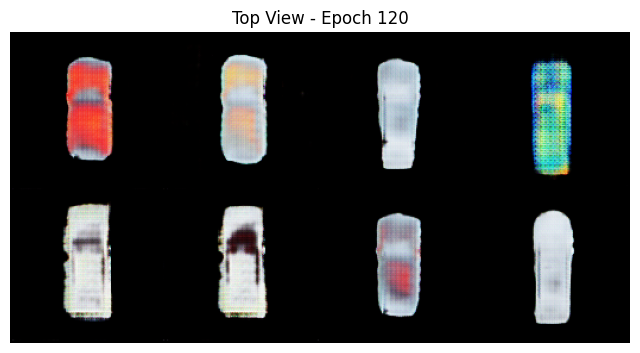

Epoch [121/200]
  Front View: D Loss: -1048.7731, G Loss: 36538.9008
  Side View:  D Loss: -1126.1713, G Loss: 24910.5028
  Top View:   D Loss: -1527.9039, G Loss: 19232.9065
Epoch [122/200]
  Front View: D Loss: -1135.6885, G Loss: 34582.4134
  Side View:  D Loss: -1295.4073, G Loss: 25290.3748
  Top View:   D Loss: -2127.9091, G Loss: 20406.7565
Epoch [123/200]
  Front View: D Loss: -1229.0622, G Loss: 34457.7797
  Side View:  D Loss: -1431.1408, G Loss: 24428.0633
  Top View:   D Loss: -1814.0703, G Loss: 19202.2356
Epoch [124/200]
  Front View: D Loss: -1239.5717, G Loss: 33992.1512
  Side View:  D Loss: -1584.6842, G Loss: 23998.9071
  Top View:   D Loss: -2094.1060, G Loss: 17728.0617
Epoch [125/200]
  Front View: D Loss: -1138.3714, G Loss: 33115.1861
  Side View:  D Loss: -1649.8238, G Loss: 22312.0393
  Top View:   D Loss: -1954.4981, G Loss: 20885.6401
Models saved at epoch 125.
Epoch [126/200]
  Front View: D Loss: -1196.2332, G Loss: 32281.3255
  Side View:  D Loss: -1715.0

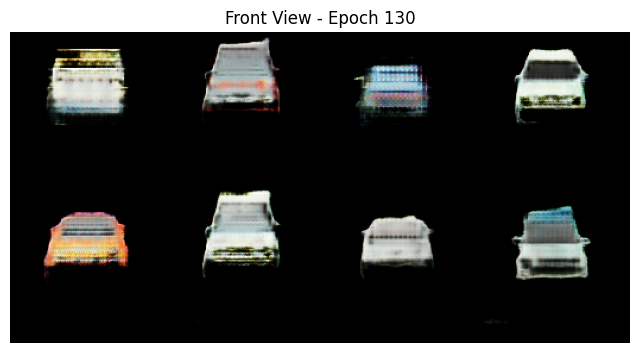

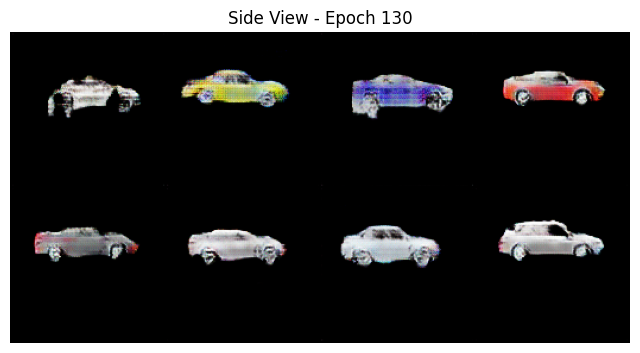

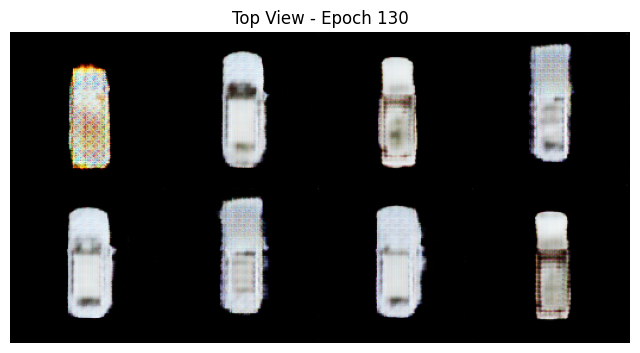

Epoch [131/200]
  Front View: D Loss: -1344.6917, G Loss: 34024.8721
  Side View:  D Loss: -1782.8666, G Loss: 19093.6538
  Top View:   D Loss: -376.1174, G Loss: 10029.1141
Epoch [132/200]
  Front View: D Loss: -1398.0938, G Loss: 32923.7985
  Side View:  D Loss: -544.3982, G Loss: 13483.1336
  Top View:   D Loss: -690.3804, G Loss: 15205.7262
Epoch [133/200]
  Front View: D Loss: -1357.0410, G Loss: 34316.1208
  Side View:  D Loss: -53.3990, G Loss: 3452.8072
  Top View:   D Loss: -1047.5647, G Loss: 19460.1578
Epoch [134/200]
  Front View: D Loss: -1385.1922, G Loss: 34170.9321
  Side View:  D Loss: 10287.8738, G Loss: 1554.1060
  Top View:   D Loss: -1524.2165, G Loss: 24945.3245
Epoch [135/200]
  Front View: D Loss: -1155.5289, G Loss: 33596.5237
  Side View:  D Loss: 509.6753, G Loss: 749.5095
  Top View:   D Loss: -1585.3630, G Loss: 24333.2677
Epoch [136/200]
  Front View: D Loss: 994.7447, G Loss: 24688.4822
  Side View:  D Loss: 277.8827, G Loss: 1915.1616
  Top View:   D Los

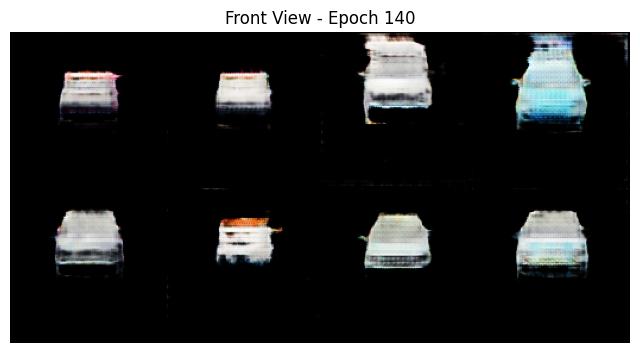

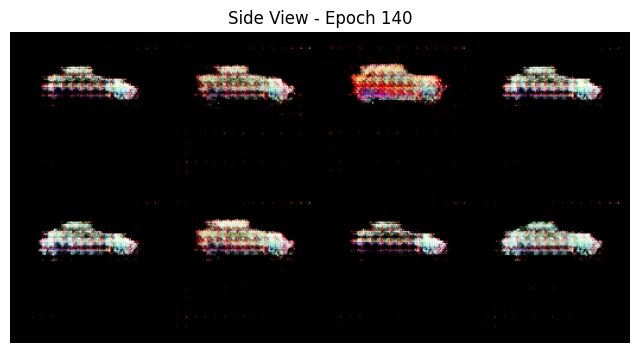

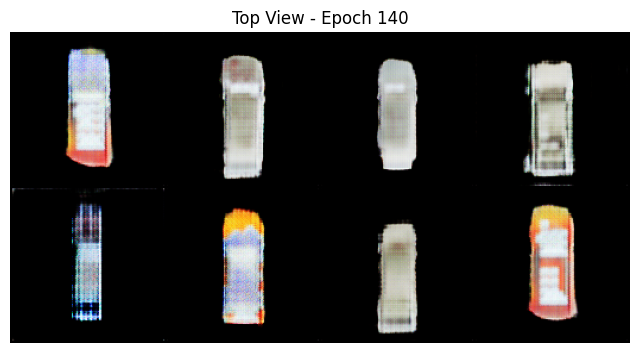

Epoch [141/200]
  Front View: D Loss: -510.1556, G Loss: 34796.3790
  Side View:  D Loss: 123.1076, G Loss: 2761.4165
  Top View:   D Loss: -1865.3385, G Loss: 22897.4674
Epoch [142/200]
  Front View: D Loss: -586.4015, G Loss: 35950.2252
  Side View:  D Loss: 165.8466, G Loss: 2429.2008
  Top View:   D Loss: -2125.1088, G Loss: 20698.2010
Epoch [143/200]
  Front View: D Loss: -895.4972, G Loss: 36409.8004
  Side View:  D Loss: 113.6924, G Loss: 2780.0278
  Top View:   D Loss: -1365.7442, G Loss: 18732.6884
Epoch [144/200]
  Front View: D Loss: -737.7172, G Loss: 37286.0713
  Side View:  D Loss: 81.8818, G Loss: 3179.4516
  Top View:   D Loss: -1648.0950, G Loss: 17819.3128
Epoch [145/200]
  Front View: D Loss: -969.9865, G Loss: 38932.5776
  Side View:  D Loss: 109.0593, G Loss: 3001.6718
  Top View:   D Loss: -1864.0532, G Loss: 18948.3794
Epoch [146/200]
  Front View: D Loss: -889.4115, G Loss: 38116.8973
  Side View:  D Loss: 53.6854, G Loss: 3203.0921
  Top View:   D Loss: -1830.3

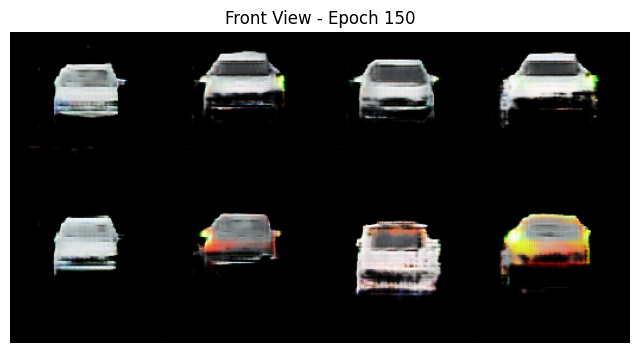

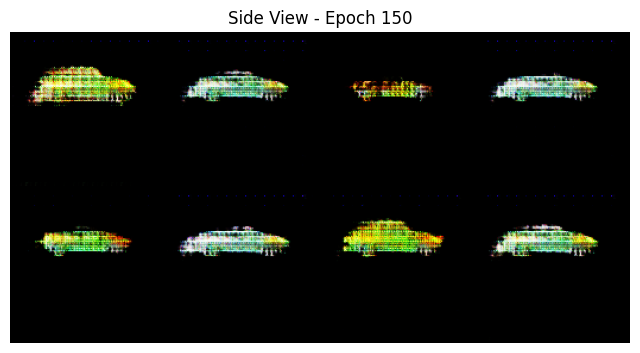

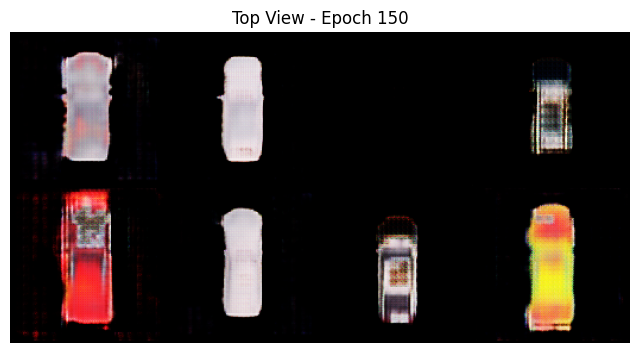

Models saved at epoch 150.
Epoch [151/200]
  Front View: D Loss: -1296.0381, G Loss: 38399.0162
  Side View:  D Loss: 27.9018, G Loss: 3584.7082
  Top View:   D Loss: -2233.1951, G Loss: 20169.7781
Epoch [152/200]
  Front View: D Loss: -1206.9148, G Loss: 35992.8473
  Side View:  D Loss: 39.1729, G Loss: 3009.3582
  Top View:   D Loss: -2023.6608, G Loss: 20156.6084
Epoch [153/200]
  Front View: D Loss: -1091.2546, G Loss: 37820.8508
  Side View:  D Loss: 36.8700, G Loss: 3102.3309
  Top View:   D Loss: -2180.1280, G Loss: 21807.9924
Epoch [154/200]
  Front View: D Loss: -1314.3692, G Loss: 36331.9693
  Side View:  D Loss: -10.1125, G Loss: 4897.2031
  Top View:   D Loss: -2169.2819, G Loss: 20660.4528
Epoch [155/200]
  Front View: D Loss: -1281.2549, G Loss: 36429.1539
  Side View:  D Loss: 16.3048, G Loss: 4337.5762
  Top View:   D Loss: -2454.2749, G Loss: 20681.9212
Epoch [156/200]
  Front View: D Loss: -1350.6371, G Loss: 36514.4349
  Side View:  D Loss: 54.2656, G Loss: 3702.9502

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torchvision import utils as vutils
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory to save checkpoints
checkpoint_dir = "/content/drive/MyDrive/CODE/saved_models/checkpoints/1/"
os.makedirs(checkpoint_dir, exist_ok=True)

# Gradient Penalty
def gradient_penalty(discriminator, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    disc_interpolates = discriminator(interpolates)
    grad_outputs = torch.ones_like(disc_interpolates, device=device)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.scale = nn.Parameter(torch.ones(1))  # Learnable scaling factor

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, height * width)
        attention = torch.bmm(query, key)
        attention = torch.softmax(attention / self.scale, dim=-1)
        value = self.value(x).view(batch_size, -1, height * width)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        return self.gamma * out + x

# Generator
class Generator(nn.Module):
    def __init__(self, text_embedding_dim, image_size):
        super(Generator, self).__init__()
        self.fc = nn.Linear(text_embedding_dim + 128, 512 * (image_size // 16) * (image_size // 16))
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SelfAttention(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SelfAttention(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, text_embeddings, noise):
        x = torch.cat((text_embeddings, noise), dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 8, 8)
        x = self.upsample(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            SelfAttention(128),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            SelfAttention(256),
            nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(512 * 8 * 8, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Load BERT for text embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def get_text_embeddings(descriptions, max_length=50):
    embeddings = []
    for description in descriptions:
        inputs = tokenizer(description, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(embedding)
    return torch.cat(embeddings, dim=0)

# Initialize models for Front, Side, and Top views
generator_front = Generator(text_embedding_dim=768, image_size=128).to(device)
generator_side = Generator(text_embedding_dim=768, image_size=128).to(device)
generator_top = Generator(text_embedding_dim=768, image_size=128).to(device)

discriminator_front = Discriminator().to(device)
discriminator_side = Discriminator().to(device)
discriminator_top = Discriminator().to(device)

# Optimizers
optimizer_G_front = optim.Adam(generator_front.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G_side = optim.Adam(generator_side.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G_top = optim.Adam(generator_top.parameters(), lr=0.0001, betas=(0.5, 0.999))

optimizer_D_front = optim.Adam(discriminator_front.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizer_D_side = optim.Adam(discriminator_side.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizer_D_top = optim.Adam(discriminator_top.parameters(), lr=0.0004, betas=(0.5, 0.999))

# Training loop
epochs = 200
for epoch in range(epochs):
    d_loss_front_total, d_loss_side_total, d_loss_top_total = 0, 0, 0
    g_loss_front_total, g_loss_side_total, g_loss_top_total = 0, 0, 0

    for descriptions, (front_real, side_real, top_real) in dataloader:
        batch_size = front_real.size(0)
        text_embeddings = get_text_embeddings(descriptions).to(device)
        noise = torch.randn(batch_size, 128).to(device)

        # Train Front Discriminator
        optimizer_D_front.zero_grad()
        fake_front = generator_front(text_embeddings, noise).detach()
        d_real = discriminator_front(front_real.to(device))
        d_fake = discriminator_front(fake_front)
        gp_front = gradient_penalty(discriminator_front, front_real.to(device), fake_front)
        d_loss_front = d_fake.mean() - d_real.mean() + 10 * gp_front
        d_loss_front.backward()
        optimizer_D_front.step()
        d_loss_front_total += d_loss_front.item()

        # Train Front Generator
        optimizer_G_front.zero_grad()
        fake_front = generator_front(text_embeddings, noise)
        g_loss_front = -discriminator_front(fake_front).mean()
        g_loss_front.backward()
        optimizer_G_front.step()
        g_loss_front_total += g_loss_front.item()

        # Train Side Discriminator
        optimizer_D_side.zero_grad()
        fake_side = generator_side(text_embeddings, noise).detach()
        d_real = discriminator_side(side_real.to(device))
        d_fake = discriminator_side(fake_side)
        gp_side = gradient_penalty(discriminator_side, side_real.to(device), fake_side)
        d_loss_side = d_fake.mean() - d_real.mean() + 10 * gp_side
        d_loss_side.backward()
        optimizer_D_side.step()
        d_loss_side_total += d_loss_side.item()

        # Train Side Generator
        optimizer_G_side.zero_grad()
        fake_side = generator_side(text_embeddings, noise)
        g_loss_side = -discriminator_side(fake_side).mean()
        g_loss_side.backward()
        optimizer_G_side.step()
        g_loss_side_total += g_loss_side.item()

        # Train Top Discriminator
        optimizer_D_top.zero_grad()
        fake_top = generator_top(text_embeddings, noise).detach()
        d_real = discriminator_top(top_real.to(device))
        d_fake = discriminator_top(fake_top)
        gp_top = gradient_penalty(discriminator_top, top_real.to(device), fake_top)
        d_loss_top = d_fake.mean() - d_real.mean() + 10 * gp_top
        d_loss_top.backward()
        optimizer_D_top.step()
        d_loss_top_total += d_loss_top.item()

        # Train Top Generator
        optimizer_G_top.zero_grad()
        fake_top = generator_top(text_embeddings, noise)
        g_loss_top = -discriminator_top(fake_top).mean()
        g_loss_top.backward()
        optimizer_G_top.step()
        g_loss_top_total += g_loss_top.item()

    # Log losses after each epoch
    print(f"Epoch [{epoch + 1}/{epochs}]")
    print(f"  Front View: D Loss: {d_loss_front_total:.4f}, G Loss: {g_loss_front_total:.4f}")
    print(f"  Side View:  D Loss: {d_loss_side_total:.4f}, G Loss: {g_loss_side_total:.4f}")
    print(f"  Top View:   D Loss: {d_loss_top_total:.4f}, G Loss: {g_loss_top_total:.4f}")

    # Visualize generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_front = generator_front(text_embeddings, noise)
            fake_side = generator_side(text_embeddings, noise)
            fake_top = generator_top(text_embeddings, noise)

        for images, title in zip([fake_front, fake_side, fake_top], ["Front View", "Side View", "Top View"]):
            grid = vutils.make_grid(images[:8], nrow=4, normalize=True)
            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.title(f"{title} - Epoch {epoch+1}")
            plt.axis("off")
            plt.show()

    # Save models every 25 epochs
    if (epoch + 1) % 25 == 0:
        torch.save(generator_front.state_dict(), os.path.join(checkpoint_dir, f"/content/drive/MyDrive/CODE/saved_models/checkpoints/1/generator_front_epoch_{epoch+1}.pth"))
        torch.save(generator_side.state_dict(), os.path.join(checkpoint_dir, f"/content/drive/MyDrive/CODE/saved_models/checkpoints/1/generator_side_epoch_{epoch+1}.pth"))
        torch.save(generator_top.state_dict(), os.path.join(checkpoint_dir, f"/content/drive/MyDrive/CODE/saved_models/checkpoints/1/generator_top_epoch_{epoch+1}.pth"))
        print(f"Models saved at epoch {epoch+1}.")
